## Self-driving car  

 In the <b>SullyChen's</b> dataset we are given with front-view images of a car while driving.The video of the car was taken for 25 mins and the video is broken into pictures captured at 30 frames/second.We are tasked to predict the angle of the angle at which the steering wheel of the car should be rotating.The given problem is a Regression problem, where we use CNN for Regression.We are going to use NVIDIA's cnn architecture to train our models.Given the input images of the front view of the car we need to predict the streering angle in degrees. We will use OpenCV to visualize the predictions.





1. hyperparameter tuning using Drop out rate as 0.5
2. Adam optimizer with learning rate 10*e-3
3. Use train-test split as 70:30
4. Use Linear activation instead of tanh

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import pi
import cv2
import scipy.misc
import seaborn as sns
import tensorflow as tf

In [2]:
#### laoding data from the dataset
folder = 'driving_dataset/'
data_f = os.path.join(folder,'data.txt')
input_,output_=[],[]
with open(data_f,'rb') as f :
     for line in f :
            line = line.decode('utf-8')
            image_name,steering_angle  = line.split()
            image_loc = os.path.join(folder,image_name)
            input_.append(image_loc)
            output_.append(float(steering_angle) * (pi / 180)) ## convert to degrees to radians

In [3]:
### 
input_len  = len(input_)
print('size of the input dataset:',len(input_))

size of the input dataset: 45406


In [4]:
print('Sample input datapoint:',input_[0],'ouput:',output_[0])
print('Sample input datapoint:',input_[67],'ouput:',output_[67])
print('Sample input datapoint:',input_[25],'ouput:',output_[25])

Sample input datapoint: driving_dataset/0.jpg ouput: 0.0
Sample input datapoint: driving_dataset/67.jpg ouput: 0.0317649923862968
Sample input datapoint: driving_dataset/25.jpg ouput: 0.18133970928221085


In [5]:
#### train-test temporal split
x_train,y_train = input_[:int(0.70 * input_len)],output_[:int(0.70 * input_len)]
x_test,y_test = input_[int(0.70 * input_len):],output_[int(0.70 * input_len):]

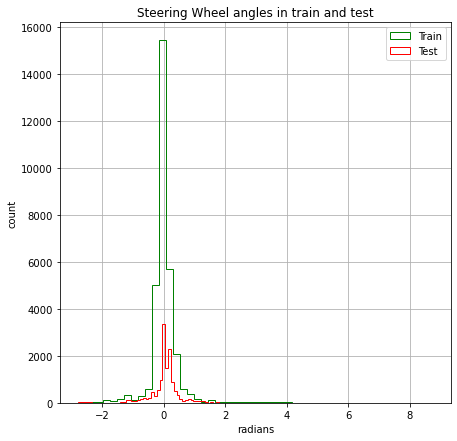

In [6]:
fig = plt.figure(figsize=(7,7))
plt.hist(y_train, bins=50,color='green', histtype ='step',label='Train')
plt.hist(y_test, bins=50,color='red', histtype ='step',label='Test')
plt.title('Steering Wheel angles in train and test')
plt.legend()
plt.xlabel('radians')
plt.ylabel('count')
plt.grid()

by the plot we can see most of the values are  0. As most time car runs on straight road we have majority values at 0.

### DataPreparation: Creating Batch Dataset

In [7]:
train_img_len = len(x_train) 
test_img_len = len(x_test)

In [35]:
train_batch_pointer = 0
test_batch_pointer = 0

In [58]:
def load_tr_te_batch(batch_size,batch_type='train'):
    global train_batch_pointer
    global test_batch_pointer
    
    if batch_type=='train':
        x_out = []
        y_out = []
        for i in range(0, batch_size):
            ## let's read batch wise data ,here the train_batch_pointer increments once a batch is loaded in our 
            ## input matrix.%train_img_len here makes sure train_batch_pointer+i do not exceed the number of imgaes in train 
            ## as we keep adding our batch 
            img_read = cv2.imread(x_train[(train_batch_pointer + i) % train_img_len])
            ### after reading the image we just want to capture the lower 150 pixels , as our steering moves 
            ## based on the anglar turns of the road , we just want to capture that
            img_read_150 = img_read[-150:]
            ## our x_train imge is of size (256, 455, 3) after selecting lower  150 , it is of size (150,455,3)
            ## we resize to 200,66,3 to keep the aspect ratio same (150/455~=66/200) 
            img_resize = cv2.resize(img_read_150,(200, 66))
            ### normalizing the pixels
            x_out.append(img_resize / 255.0)
            y_out.append([y_train[(train_batch_pointer + i) % train_img_len]])
        train_batch_pointer += batch_size 
        return x_out, y_out
    else:
        x_out = []
        y_out = []
        for i in range(0, batch_size):
            img_read = cv2.imread(x_test[(test_batch_pointer + i) % test_img_len])
            img_read_150 = img_read[-150:]
            img_resize = cv2.resize(img_read_150,(200, 66))
            ### normalizing the pixels
            x_out.append(img_resize / 255.0)
            y_out.append([y_test[(test_batch_pointer + i) % test_img_len]])
        test_batch_pointer += batch_size 
        return x_out, y_out
        
    

#### Building Model Architecture

<img src='cnn.png'></img>

In [54]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

x = tf.placeholder(tf.float32, shape=[None, 66, 200, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

x_image = x ## shape of x_imgae == (,66*200*3)

#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1) ## stride==2,shape(24@31x98)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2) ## stride==2,shape(36@14x47)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3) ## stride==2,shape(48@5x22)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64])   
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4) ## stride==1,shape(64@3x20)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5) ## stride==1,shape(64@1x18)

#FCL 1
W_fc1 = weight_variable([1152, 1164]) ### 1164 nurons for faltetn layer 1 
b_fc1 = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152]) ### our flatten layer is of shape 1*1152 
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1) ## here we are performing matrix multiplication 
## between (1*1152) x (1152*1164)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob) ### adding a dropout layer 

#FCL 2
W_fc2 = weight_variable([1164, 100]) ### 100 nurons for faltetn layer 2 
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)  ### adding a dropout layer 

#FCL 3
W_fc3 = weight_variable([100, 50]) ### 50 nurons for flatten layer 3
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)  ### adding a dropout layer 

#final flatten layer 4
W_fc4 = weight_variable([50, 10]) ### 10 nurons for flatten layer 4
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)  ### adding a dropout layer 

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

y = tf.identity(tf.matmul(h_fc4_drop, W_fc5) + b_fc5)  #scale the  output

### Train the model

In [62]:
### creating a new session
save_folder = '/Save/'
session =  tf.InteractiveSession()
## let's define our loss 
## loss == Mean Squared Error + L2norm
l2normconst = 0.001
train_variables = tf.trainable_variables() ## returns all the variables which are trainable i.e wweights and biases
loss  = tf.reduce_mean(tf.square(tf.subtract(y_,y))) + tf.add_n([tf.nn.l2_loss(w) for w in train_variables])*l2normconst
    
### optimize using Adam with learning rate 10*e-3
trainstep = tf.train.AdamOptimizer(1e-4).minimize(loss)
session.run(tf.initialize_all_variables())

saver = tf.train.Saver()

epochs = 30
batch_size = 100
save_epoch_result =[] 
print('*'*5,'Epochs And losses','*'*5)
for epoch in range(epochs):
    avg_loss_test,avg_loss_train=0,0
    for i in range(int(input_len/batch_size)):
        x_batch,y_batch = load_tr_te_batch(batch_size)
        trainstep.run(feed_dict = {x:x_batch,y_:y_batch,keep_prob:0.5})  ### 
        train_loss = loss.eval(feed_dict = {x:x_batch,y_:y_batch,keep_prob:1.0})
        avg_loss_train += train_loss  / batch_size
        
        
        x_batch_test,y_batch_test = load_tr_te_batch(batch_size,'test')
        test_loss = loss.eval(feed_dict = {x:x_batch_test,y_:y_batch_test,keep_prob:1.0})
        avg_loss_test += test_loss / batch_size
        
        if i % 10 == 0:
            print("Epoch: %d, Step: %d, val Loss: %g" % (epoch, epoch * batch_size + i, test_loss))
        if i % batch_size == 0:
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            checkpoint_path = os.path.join(save_folder, "model.ckpt")
            filename = saver.save(session, checkpoint_path)
            print("Model saved in file: %s" % filename)
        
    save_epoch_result.append((epoch,train_loss,test_loss,avg_loss_train,avg_loss_test))
        

C:\Users\sundararaman\anaconda3\envs\tf-3\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


***** Epochs And losses *****
Epoch: 0, Step: 0, val Loss: 45.8983
Model saved in file: /Save/model.ckpt
Epoch: 0, Step: 10, val Loss: 43.7364
Epoch: 0, Step: 20, val Loss: 41.6907
Epoch: 0, Step: 30, val Loss: 41.4254
Epoch: 0, Step: 40, val Loss: 40.2671
Epoch: 0, Step: 50, val Loss: 41.3627
Epoch: 0, Step: 60, val Loss: 38.9116
Epoch: 0, Step: 70, val Loss: 38.2499
Epoch: 0, Step: 80, val Loss: 37.6567
Epoch: 0, Step: 90, val Loss: 37.0938
Epoch: 0, Step: 100, val Loss: 36.3424
Model saved in file: /Save/model.ckpt
Epoch: 0, Step: 110, val Loss: 35.7267
Epoch: 0, Step: 120, val Loss: 35.215
Epoch: 0, Step: 130, val Loss: 35.3167
Epoch: 0, Step: 140, val Loss: 35.6502
Epoch: 0, Step: 150, val Loss: 33.421
Epoch: 0, Step: 160, val Loss: 33.2357
Epoch: 0, Step: 170, val Loss: 32.3413
Epoch: 0, Step: 180, val Loss: 31.9243
Epoch: 0, Step: 190, val Loss: 31.2219
Epoch: 0, Step: 200, val Loss: 30.7225
Model saved in file: /Save/model.ckpt
Epoch: 0, Step: 210, val Loss: 30.2039
Epoch: 0, S

Epoch: 4, Step: 460, val Loss: 3.37656
Epoch: 4, Step: 470, val Loss: 3.35655
Epoch: 4, Step: 480, val Loss: 3.32364
Epoch: 4, Step: 490, val Loss: 3.30525
Epoch: 4, Step: 500, val Loss: 3.41991
Model saved in file: /Save/model.ckpt
Epoch: 4, Step: 510, val Loss: 3.32455
Epoch: 4, Step: 520, val Loss: 3.28015
Epoch: 4, Step: 530, val Loss: 3.28661
Epoch: 4, Step: 540, val Loss: 3.18687
Epoch: 4, Step: 550, val Loss: 3.16626
Epoch: 4, Step: 560, val Loss: 3.14287
Epoch: 4, Step: 570, val Loss: 3.12312
Epoch: 4, Step: 580, val Loss: 3.18086
Epoch: 4, Step: 590, val Loss: 3.21347
Epoch: 4, Step: 600, val Loss: 3.07343
Model saved in file: /Save/model.ckpt
Epoch: 4, Step: 610, val Loss: 3.15303
Epoch: 4, Step: 620, val Loss: 3.18121
Epoch: 4, Step: 630, val Loss: 3.5216
Epoch: 4, Step: 640, val Loss: 3.0661
Epoch: 4, Step: 650, val Loss: 3.0124
Epoch: 4, Step: 660, val Loss: 3
Epoch: 4, Step: 670, val Loss: 3.32071
Epoch: 4, Step: 680, val Loss: 2.92093
Epoch: 4, Step: 690, val Loss: 2.913

Epoch: 8, Step: 920, val Loss: 1.79443
Epoch: 8, Step: 930, val Loss: 1.79134
Epoch: 8, Step: 940, val Loss: 1.7984
Epoch: 8, Step: 950, val Loss: 1.79599
Epoch: 8, Step: 960, val Loss: 2.11031
Epoch: 8, Step: 970, val Loss: 1.82492
Epoch: 8, Step: 980, val Loss: 1.79463
Epoch: 8, Step: 990, val Loss: 1.77157
Epoch: 8, Step: 1000, val Loss: 2.64818
Model saved in file: /Save/model.ckpt
Epoch: 8, Step: 1010, val Loss: 1.78004
Epoch: 8, Step: 1020, val Loss: 1.79101
Epoch: 8, Step: 1030, val Loss: 1.75769
Epoch: 8, Step: 1040, val Loss: 1.75651
Epoch: 8, Step: 1050, val Loss: 1.74853
Epoch: 8, Step: 1060, val Loss: 1.74439
Epoch: 8, Step: 1070, val Loss: 1.77396
Epoch: 8, Step: 1080, val Loss: 1.84944
Epoch: 8, Step: 1090, val Loss: 1.75244
Epoch: 8, Step: 1100, val Loss: 2.01012
Model saved in file: /Save/model.ckpt
Epoch: 8, Step: 1110, val Loss: 2.57258
Epoch: 8, Step: 1120, val Loss: 2.22528
Epoch: 8, Step: 1130, val Loss: 1.78696
Epoch: 8, Step: 1140, val Loss: 1.7448
Epoch: 8, Step

Epoch: 12, Step: 1330, val Loss: 1.51069
Epoch: 12, Step: 1340, val Loss: 1.35123
Epoch: 12, Step: 1350, val Loss: 1.22356
Epoch: 12, Step: 1360, val Loss: 1.25436
Epoch: 12, Step: 1370, val Loss: 1.27184
Epoch: 12, Step: 1380, val Loss: 1.5981
Epoch: 12, Step: 1390, val Loss: 1.18716
Epoch: 12, Step: 1400, val Loss: 1.20737
Model saved in file: /Save/model.ckpt
Epoch: 12, Step: 1410, val Loss: 1.18241
Epoch: 12, Step: 1420, val Loss: 2.90828
Epoch: 12, Step: 1430, val Loss: 1.19296
Epoch: 12, Step: 1440, val Loss: 1.18204
Epoch: 12, Step: 1450, val Loss: 1.20924
Epoch: 12, Step: 1460, val Loss: 1.17835
Epoch: 12, Step: 1470, val Loss: 1.60741
Epoch: 12, Step: 1480, val Loss: 1.4104
Epoch: 12, Step: 1490, val Loss: 2.18041
Epoch: 12, Step: 1500, val Loss: 1.17691
Model saved in file: /Save/model.ckpt
Epoch: 12, Step: 1510, val Loss: 1.15898
Epoch: 12, Step: 1520, val Loss: 1.15095
Epoch: 12, Step: 1530, val Loss: 1.14692
Epoch: 12, Step: 1540, val Loss: 1.14403
Epoch: 12, Step: 1550, v

Model saved in file: /Save/model.ckpt
Epoch: 16, Step: 1710, val Loss: 1.2288
Epoch: 16, Step: 1720, val Loss: 0.745905
Epoch: 16, Step: 1730, val Loss: 0.749904
Epoch: 16, Step: 1740, val Loss: 0.734129
Epoch: 16, Step: 1750, val Loss: 0.736546
Epoch: 16, Step: 1760, val Loss: 0.726241
Epoch: 16, Step: 1770, val Loss: 0.724429
Epoch: 16, Step: 1780, val Loss: 0.736467
Epoch: 16, Step: 1790, val Loss: 0.828606
Epoch: 16, Step: 1800, val Loss: 0.749753
Model saved in file: /Save/model.ckpt
Epoch: 16, Step: 1810, val Loss: 1.11253
Epoch: 16, Step: 1820, val Loss: 1.47187
Epoch: 16, Step: 1830, val Loss: 1.58758
Epoch: 16, Step: 1840, val Loss: 0.804866
Epoch: 16, Step: 1850, val Loss: 0.72808
Epoch: 16, Step: 1860, val Loss: 1.46232
Epoch: 16, Step: 1870, val Loss: 0.831522
Epoch: 16, Step: 1880, val Loss: 0.713622
Epoch: 16, Step: 1890, val Loss: 0.707957
Epoch: 16, Step: 1900, val Loss: 0.699291
Model saved in file: /Save/model.ckpt
Epoch: 16, Step: 1910, val Loss: 4.1009
Epoch: 16, St

Epoch: 20, Step: 2050, val Loss: 0.874605
Epoch: 20, Step: 2060, val Loss: 0.448176
Epoch: 20, Step: 2070, val Loss: 0.564778
Epoch: 20, Step: 2080, val Loss: 0.509761
Epoch: 20, Step: 2090, val Loss: 0.562246
Epoch: 20, Step: 2100, val Loss: 0.410209
Model saved in file: /Save/model.ckpt
Epoch: 20, Step: 2110, val Loss: 0.403984
Epoch: 20, Step: 2120, val Loss: 0.481702
Epoch: 20, Step: 2130, val Loss: 0.633657
Epoch: 20, Step: 2140, val Loss: 0.413634
Epoch: 20, Step: 2150, val Loss: 0.391852
Epoch: 20, Step: 2160, val Loss: 0.408711
Epoch: 20, Step: 2170, val Loss: 0.431101
Epoch: 20, Step: 2180, val Loss: 0.631007
Epoch: 20, Step: 2190, val Loss: 0.446029
Epoch: 20, Step: 2200, val Loss: 1.37895
Model saved in file: /Save/model.ckpt
Epoch: 20, Step: 2210, val Loss: 0.41149
Epoch: 20, Step: 2220, val Loss: 0.385732
Epoch: 20, Step: 2230, val Loss: 0.393909
Epoch: 20, Step: 2240, val Loss: 0.379334
Epoch: 20, Step: 2250, val Loss: 0.375541
Epoch: 20, Step: 2260, val Loss: 0.373314
Ep

Epoch: 24, Step: 2400, val Loss: 0.241993
Model saved in file: /Save/model.ckpt
Epoch: 24, Step: 2410, val Loss: 0.24405
Epoch: 24, Step: 2420, val Loss: 0.4325
Epoch: 24, Step: 2430, val Loss: 0.229093
Epoch: 24, Step: 2440, val Loss: 0.235194
Epoch: 24, Step: 2450, val Loss: 0.245497
Epoch: 24, Step: 2460, val Loss: 0.224552
Epoch: 24, Step: 2470, val Loss: 0.223472
Epoch: 24, Step: 2480, val Loss: 0.22074
Epoch: 24, Step: 2490, val Loss: 0.222857
Epoch: 24, Step: 2500, val Loss: 0.32464
Model saved in file: /Save/model.ckpt
Epoch: 24, Step: 2510, val Loss: 0.236783
Epoch: 24, Step: 2520, val Loss: 0.547955
Epoch: 24, Step: 2530, val Loss: 0.496182
Epoch: 24, Step: 2540, val Loss: 0.805678
Epoch: 24, Step: 2550, val Loss: 0.374443
Epoch: 24, Step: 2560, val Loss: 0.301108
Epoch: 24, Step: 2570, val Loss: 0.340432
Epoch: 24, Step: 2580, val Loss: 0.530788
Epoch: 24, Step: 2590, val Loss: 0.255759
Epoch: 24, Step: 2600, val Loss: 0.302136
Model saved in file: /Save/model.ckpt
Epoch: 24

Model saved in file: /Save/model.ckpt
Epoch: 27, Step: 3110, val Loss: 0.215617
Epoch: 27, Step: 3120, val Loss: 0.598393
Epoch: 27, Step: 3130, val Loss: 0.169722
Epoch: 27, Step: 3140, val Loss: 0.230464
Epoch: 27, Step: 3150, val Loss: 0.293157
Epoch: 28, Step: 2800, val Loss: 0.338457
Model saved in file: /Save/model.ckpt
Epoch: 28, Step: 2810, val Loss: 0.417877
Epoch: 28, Step: 2820, val Loss: 0.270314
Epoch: 28, Step: 2830, val Loss: 0.307838
Epoch: 28, Step: 2840, val Loss: 0.203017
Epoch: 28, Step: 2850, val Loss: 0.16886
Epoch: 28, Step: 2860, val Loss: 0.163957
Epoch: 28, Step: 2870, val Loss: 0.337167
Epoch: 28, Step: 2880, val Loss: 0.200319
Epoch: 28, Step: 2890, val Loss: 0.199825
Epoch: 28, Step: 2900, val Loss: 0.168026
Model saved in file: /Save/model.ckpt
Epoch: 28, Step: 2910, val Loss: 0.398381
Epoch: 28, Step: 2920, val Loss: 0.192315
Epoch: 28, Step: 2930, val Loss: 0.187394
Epoch: 28, Step: 2940, val Loss: 0.189653
Epoch: 28, Step: 2950, val Loss: 0.17217
Epoch:

In [67]:
# epoch,train_loss,test_loss,avg_loss_train,avg_loss_test)
pd.DataFrame.from_records(save_epoch_result).rename(columns={0:'Epoch',1:'train_loss',
                                                             2: 'test_loss',3: 'avg_loss_train',
                                                             4 : 'avg_loss_test'
                                                    })

,Epoch,train_loss,test_loss,avg_loss_train,avg_loss_test
0,0,20.309345,20.450747,138.312175,138.158582
1,1,10.222139,10.270148,67.179377,67.063772
2,2,5.709777,5.542916,35.780934,35.154106
3,3,4.982380,3.708878,21.111501,21.092149
4,4,2.671522,2.820400,15.538116,14.905212
5,5,2.317737,2.267380,12.200914,12.122510
6,6,2.020299,2.216355,11.352155,10.821257
7,7,1.869701,1.961733,10.032722,9.852861
8,8,1.674673,1.682330,9.180265,9.005918
9,9,1.668034,1.770391,8.910349,8.358817


* We can observe that as the epoch increases  test loss test and average test loss  decreases 

#### Running the model

In [1]:
# Let's run our model

## let's restore our model after training 

sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "save/model.ckpt")


## read the steering wheel image 
steering_image = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = steering_image.shape

## we want to see the test predicted values 


test_idx = math.ceil(input_len*0.8)

print('*'*100)
print('\n\n\n')
print('Displaying video frame from '+' datapoint '+ str(int(test_idx)))
print('\n\n\n')
print('*'*100)

smoothed_angle=0
while(cv2.waitKey(50) != ord('q')):
     full_image = scipy.misc.imread('driving_dataset/'+str(test_idx)+'.jpg',mode='RGB')
     ## extracting just the below 150 pixels and resizing it into 66,200 and normalizing the image 
     image_150 =  full_image[-150:]
     resize_img = scipy.misc.imresize(image_150,(66,200))
     ## normalize img
     norm_img = resize_img / 255

     ## evaluate and convert to degrees

     degrees_predicted = y.eval(feed_dict={x: [norm_img], keep_prob: 1.0})[0][0] * 180.0 / scipy.pi
     degrees_actual = str(output_[test_idx]*180/scipy.pi)

     print("Steering angle: " + str(degrees_predicted) + " (pred)\t" + degrees_actual + " (actual)"
            + "  absolute error : "+ str(round(abs(float(degrees_actual)-float(degrees_predicted)),2)))

     cv2.imshow("frame", cv2.cvtColor(full_image, cv2.COLOR_RGB2BGR))
     smoothed_angle += 0.2 * pow(abs((degrees_predicted - smoothed_angle)), 2.0 / 3.0) * (degrees_predicted - smoothed_angle) / abs(degrees_predicted - smoothed_angle)
     M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1)
     ## performing affine transformation using cv2.wrapAffine (i.e) using this we preserve 
     ## collinearity, parallelism as well as the ratio of distances between the points  after rotation 
     dst = cv2.warpAffine(steering_image,M,(cols,rows))
     cv2.imshow("steering wheel", dst)
     test_idx += 1




#### run the file self_driving_assignment.py in command prompt to visualize the output